## 1. Introdução

Grupo:
- Arthur Wanderley Ferreira dos Santos (awfs@cesar.school)
- Thiago Wanderley Amorim (twa@cesar.school)

Dataset:

In [1]:
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from prophet import Prophet

warnings.filterwarnings('ignore')

c:\Users\Administrador\Documents\Series_Temporais\Trabalho Final\venv_series\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
#Função para fazer a leitura dos datasets -- Obs.: Retirado os dados da Pandemia!
def download_and_process_energy_data():
    urls = [
        "https://ons-aws-prod-opendata.s3.amazonaws.com/dataset/carga_energia_di/CARGA_ENERGIA_2024.xlsx",
        "https://ons-aws-prod-opendata.s3.amazonaws.com/dataset/carga_energia_di/CARGA_ENERGIA_2023.xlsx"#,
        #"https://ons-aws-prod-opendata.s3.amazonaws.com/dataset/carga_energia_di/CARGA_ENERGIA_2022.xlsx",
    ]
    
    dataframes = [pd.read_excel(url) for url in urls]
    df = pd.concat(dataframes, ignore_index=True)
    df = df.groupby("din_instante", as_index=False)["val_cargaenergiamwmed"].sum()
    
    return df

In [3]:
data = download_and_process_energy_data()

In [4]:
data.head()

,din_instante,val_cargaenergiamwmed
0,2023-01-01,56341.493833
1,2023-01-02,66878.872917
2,2023-01-03,70158.630792
3,2023-01-04,70184.753000
4,2023-01-05,68949.606458


              din_instante  val_cargaenergiamwmed
count                  731             731.000000
mean   2024-01-01 00:00:00           76327.355566
min    2023-01-01 00:00:00           56341.493833
25%    2023-07-02 12:00:00           71532.856229
50%    2024-01-01 00:00:00           76437.876625
75%    2024-07-01 12:00:00           81673.891458
max    2024-12-31 00:00:00           91359.725708
std                    NaN            6952.556661


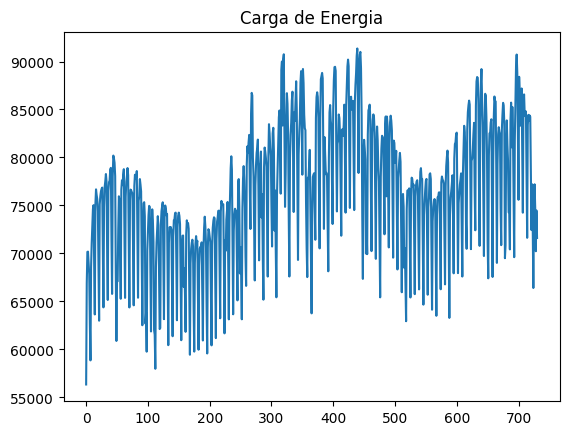

In [5]:
data['val_cargaenergiamwmed'].plot(title='Carga de Energia')
print(data.describe())

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

<Axes: >

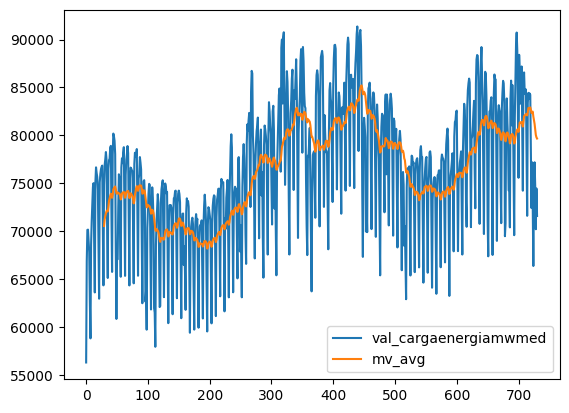

In [7]:
def create_mv_avg(df, mv_size):
  return df.rolling(mv_size).mean().values

mv_size = 30
data["mv_avg"] = create_mv_avg(data["val_cargaenergiamwmed"], mv_size)
data[["val_cargaenergiamwmed", "mv_avg"]].plot()

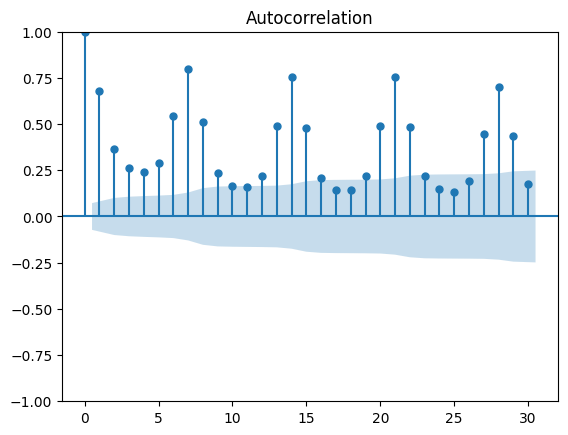

In [8]:
plot_acf(data['val_cargaenergiamwmed'],lags=30)
plt.show()

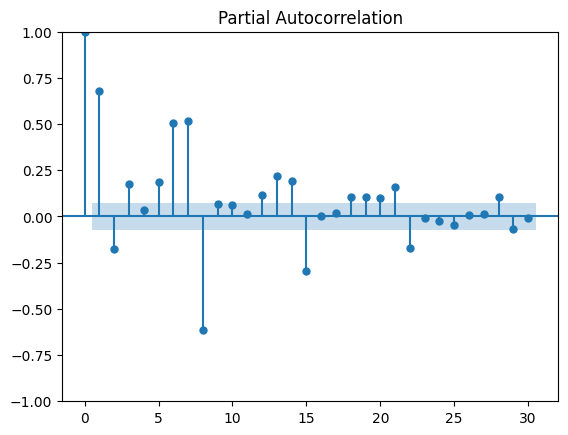

In [9]:
plot_pacf(data['val_cargaenergiamwmed'],lags=30)
plt.show()

In [10]:
def test_kpss(timeseries):
    kpss_result = kpss(timeseries, regression='c')
    
    print("Teste KPSS:")
    print(f"   Estatística de Teste: {kpss_result[0]}")
    print(f"   p-valor: {kpss_result[1]}")
    print("   Valores Críticos:")
    for key, value in kpss_result[3].items():
        print(f"      {key}: {value}")
    if kpss_result[1] < 0.05:
        print("   A série NÃO é estacionária pelo teste KPSS.")
    else:
        print("   A série é estacionária pelo teste KPSS.")

test_kpss(data['val_cargaenergiamwmed'])

Teste KPSS:
   Estatística de Teste: 2.254431962095681
   p-valor: 0.01
   Valores Críticos:
      10%: 0.347
      5%: 0.463
      2.5%: 0.574
      1%: 0.739
   A série NÃO é estacionária pelo teste KPSS.


In [11]:
def get_diff(tseries, m=1):
  diffs = []
  for t in range(m, len(tseries)):
    diffs.append(tseries.values[t] - tseries.values[t - m])

  return pd.DataFrame({f"Diff(m={m})": diffs})

<Axes: >

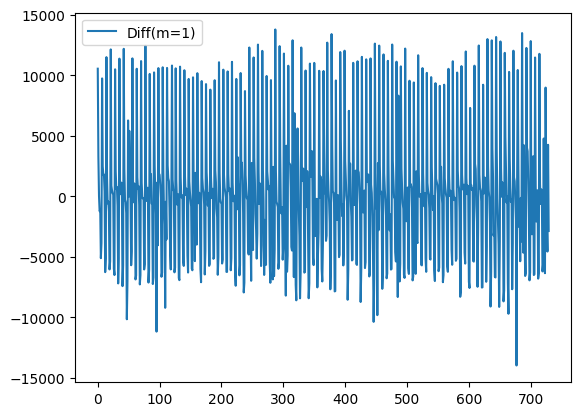

In [12]:
data_diff = get_diff(data['val_cargaenergiamwmed'], m=1)
data_diff.plot()

In [13]:
test_kpss(data_diff)

Teste KPSS:
   Estatística de Teste: 0.20072740124240646
   p-valor: 0.1
   Valores Críticos:
      10%: 0.347
      5%: 0.463
      2.5%: 0.574
      1%: 0.739
   A série é estacionária pelo teste KPSS.


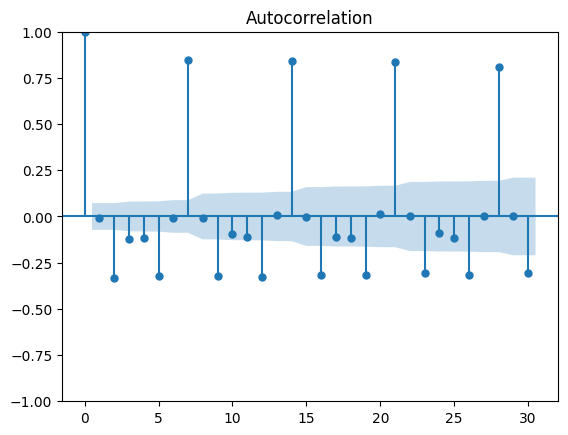

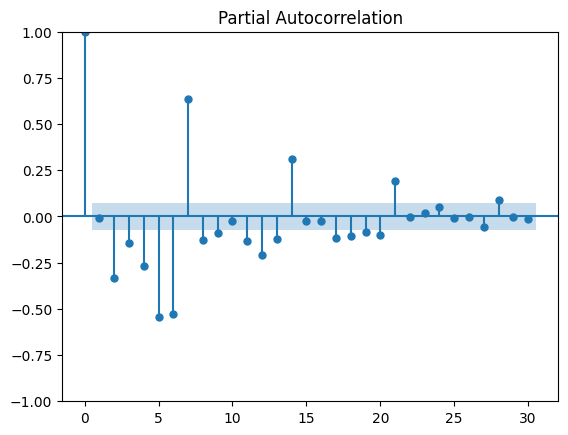

In [14]:
plot_acf(data_diff,lags=30)
plot_pacf(data_diff,lags=30)
plt.show()

Aplica normalização

In [15]:
# Criar features temporais para capturar sazonalidade
data['month'] = data['din_instante'].dt.month
data['weekday'] = data['din_instante'].dt.weekday
data = data.drop(columns=['mv_avg'])

In [16]:
# Normalizar os dados
scaler = MinMaxScaler()
data[['val_cargaenergiamwmed_std']] = scaler.fit_transform(data[['val_cargaenergiamwmed']])

In [17]:
data.head()

,din_instante,val_cargaenergiamwmed,month,weekday,val_cargaenergiamwmed_std
0,2023-01-01,56341.493833,1,6,0.000000
1,2023-01-02,66878.872917,1,0,0.300911
2,2023-01-03,70158.630792,1,1,0.394570
3,2023-01-04,70184.753000,1,2,0.395316
4,2023-01-05,68949.606458,1,3,0.360044


In [18]:
# Criar conjunto de treino e teste com features temporais
features = ['month', 'weekday']
X = data[features]
y = data['val_cargaenergiamwmed_std']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [19]:
#Medidas de avaliação
def evaluate(y_true, y_pred):
    return {
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

In [30]:
# Auto-ARIMA m=30
auto_arima_model_m30 = auto_arima(y_train, seasonal=True, m=30, stepwise=True, trace=True, suppress_warnings=True, error_action='ignore', maxiter=50, n_jobs=-1)
auto_arima_preds_m30 = auto_arima_model_m30.predict(n_periods=len(y_test))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=-728.533, Time=2.24 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=-508.717, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=-562.544, Time=0.38 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=-607.112, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=-510.687, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[30] intercept   : AIC=-734.573, Time=1.96 sec
 ARIMA(2,1,2)(0,0,0)[30] intercept   : AIC=-712.479, Time=0.28 sec
 ARIMA(2,1,2)(0,0,2)[30] intercept   : AIC=-745.523, Time=8.37 sec
 ARIMA(2,1,2)(1,0,2)[30] intercept   : AIC=-741.349, Time=9.35 sec
 ARIMA(1,1,2)(0,0,2)[30] intercept   : AIC=-735.126, Time=7.44 sec
 ARIMA(2,1,1)(0,0,2)[30] intercept   : AIC=-741.067, Time=7.48 sec
 ARIMA(3,1,2)(0,0,2)[30] intercept   : AIC=-742.751, Time=9.34 sec
 ARIMA(2,1,3)(0,0,2)[30] intercept   : AIC=-861.970, Time=11.24 sec
 ARIMA(2,1,3)(0,0,1)[30] intercept   : AIC=-891.189, Time=2.72 sec
 ARIMA(2,1,3)(0,0,

In [31]:
# Auto-ARIMA m=7
auto_arima_model_m7 = auto_arima(y_train, seasonal=True, m=7, stepwise=True, trace=True, suppress_warnings=True, error_action='ignore', maxiter=50, n_jobs=-1)
auto_arima_preds_m7 = auto_arima_model_m7.predict(n_periods=len(y_test))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=-1530.710, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-508.717, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-1240.004, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-833.914, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-510.687, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=-978.571, Time=0.59 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=-1295.941, Time=0.48 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=-1530.336, Time=1.13 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=-1487.439, Time=1.09 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=-712.479, Time=0.28 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=-1074.490, Time=0.98 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=-1425.253, Time=0.93 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=inf, Time=1.36 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=-1531.118, Time=0.83 sec
 ARIMA(1,1,2)(0,0,1)[7] interc

In [32]:
# Reverter normalização para valores reais
auto_arima_preds_m30 = scaler.inverse_transform(auto_arima_preds_m30.values.reshape(-1, 1)).flatten()
auto_arima_preds_m7 = scaler.inverse_transform(auto_arima_preds_m7.values.reshape(-1, 1)).flatten()
y_test_real = scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

In [33]:
metrics_auto_arima_m30 = evaluate(y_test_real, auto_arima_preds_m30)
metrics_auto_arima_m7 = evaluate(y_test_real, auto_arima_preds_m7)

In [ ]:
# Modelo de Redes Neurais com ReLU
mlp = MLPRegressor(
    hidden_layer_sizes=(200, 100, 50),
    activation='relu',  # Função de ativação ReLU
    solver='adam',
    learning_rate='adaptive',
    alpha=0.001,  # Ajuste de regularização
    max_iter=2000,
    early_stopping=True,
    random_state=42
)

In [44]:
mlp.fit(X_train, y_train)
mlp_preds = mlp.predict(X_test)

In [45]:
# Reverter normalização para valores reais
mlp_preds = scaler.inverse_transform(mlp_preds.reshape(-1, 1)).flatten()

# Atualizar métricas
metrics_mlp = evaluate(y_test_real, mlp_preds)

In [46]:
# Comparação de Modelos
results = pd.DataFrame({'Auto-ARIMA m=30': metrics_auto_arima_m30, 'Auto-ARIMA m=7': metrics_auto_arima_m7, 'MLP': metrics_mlp})
print("\nMétricas Comparativas:")
print(results)


Métricas Comparativas:
      Auto-ARIMA m=30  Auto-ARIMA m=7           MLP
MSE      2.068448e+07    2.567374e+07  2.184270e+07
RMSE     4.548019e+03    5.066926e+03  4.673617e+03
MAE      3.257419e+03    4.237240e+03  3.834861e+03


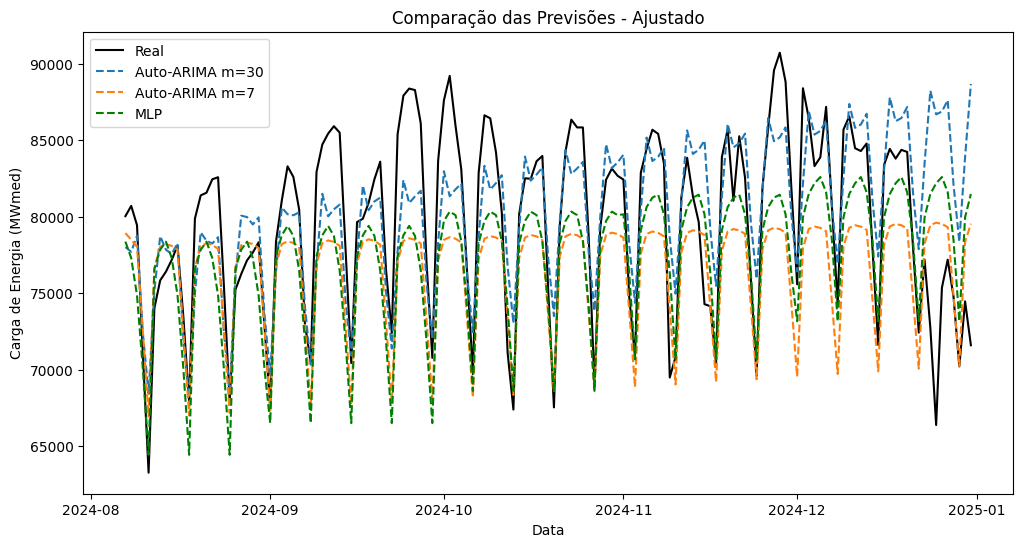

In [47]:
# Plot das Previsões Ajustadas
plt.figure(figsize=(12,6))
plt.plot(data['din_instante'].iloc[-len(y_test):], y_test_real, label='Real', color='black')
plt.plot(data['din_instante'].iloc[-len(y_test):], auto_arima_preds_m30, label='Auto-ARIMA m=30', linestyle='dashed')
plt.plot(data['din_instante'].iloc[-len(y_test):], auto_arima_preds_m7, label='Auto-ARIMA m=7', linestyle='dashed')
plt.plot(data['din_instante'].iloc[-len(y_test):], mlp_preds, label='MLP', linestyle='dashed', color='green')
plt.legend()
plt.title('Comparação das Previsões - Ajustado')
plt.xlabel('Data')
plt.ylabel('Carga de Energia (MWmed)')
plt.show()